# Exploration 8. Image Segmentation. 인물사진 모드 만들기

피사체를 가깝게 찍을 때 배경이 흐려지는 효과를 경험해 보신 적이 있으신가요?  

보통은 DSLR이나 미러리스 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과이다. 하지만 피사체를 충분히 가까운 거리에 두고 촬영한다면 핸드폰 카메라에서도 비슷한 효과를 낼 수 있다.

특히 2개 이상의 렌즈를 탑재한 최신 핸드폰에서는 __인물사진 모드(portrait mode)__ 를 지원한다.

한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현한다.   

하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 __얕은 피사계 심도(shallow depth of field)__ 또는 __셸로우 포커스(shallow focus)__ 이다.  

딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

![image](https://user-images.githubusercontent.com/84179578/128794865-4f3f82b5-4d65-4ba2-a1af-586a17946707.png)

하나의 카메라로 shallow focus 를 만드는 방법은 다음과 같다.


- 1. 배경이 있는 인물 사진을 불러온다. (배경과 사람의 거리가 약간 멀리 있으면 좋음)
- 2. 시멘틱 세그멘테이션 (Semantic segmentation) 으로 피사체(사람)와 배경을 분리
- 3. 블러링 (blurring) 기술로 배경을 흐리게 함
- 4. 피사체를 배경의 원래 위치에 합성

![image](https://user-images.githubusercontent.com/84179578/128795249-8bee6fb8-8392-43e9-b31b-5dfc33fdf603.png)

이제 본격적으로 shallow focus 를 인물 사진에 적용해보자.

----

## 1. 사진 불러오기

기존의 사진을 디렉토리에 저장한다. 사용할 디렉토리 구조는 아래와 같다.
```
─ aiffel/hunman_segmentation
    ├── models
           └── deeplab_model.tar.gz
    ├── images
           └── leejaejun1.jpg
           └── leejaejun2.jpg
           
```

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/leejaejun1.jpg'  
img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/leejaejun2.jpg'  

img1_orig = cv2.imread(img1_path) 
img2_orig = cv2.imread(img2_path) 
print (img1_orig.shape)
print (img2_orig.shape)

(2560, 1920, 3)
(1440, 1440, 3)


불러온 이미지를 확인해보자.

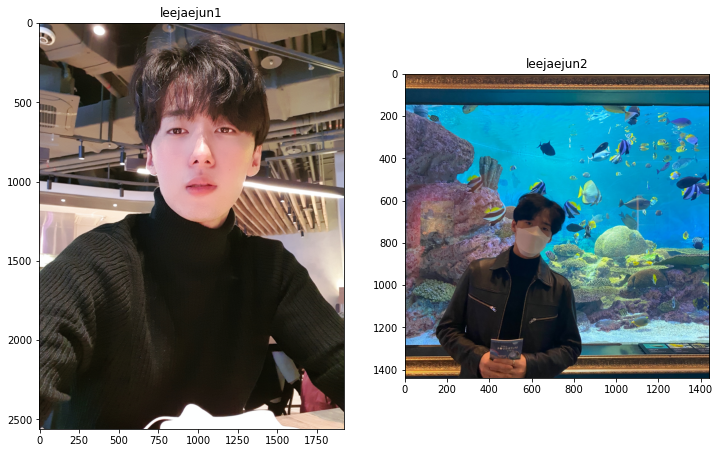

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))
plt.title('leejaejun1')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.title('leejaejun2')
plt.show()

## 2. Segmentation 으로 사람 분리

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 __이미지 세그멘테이션(image segmentation)__ 이라고 한다.

segmentation 에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다. 

segmentation 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 segmentation 을 __시맨틱 세그멘테이션 (semantic segmentation)__ 이라고 한다.  
쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이다.  

이외에도 
- 인스턴스 세그멘테이션 (Instance segmentation)
- 워터쉐드 세그멘테이션 (watershed segmentation)  

등 이 존재한다. 개념에 대한 자세한 내용은 블로그를 참조
> 블로그 링크

## 3. Semantic segmentation

본격적으로 세그멘테이션을 구현해보자.  

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠다.

구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들자.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- `preprocess()` : 이미지 전처리 함수 (모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정)
- `run()` : 실제로 세그멘테이션을 하는 함수

사전에 학습된 가중치(pretrained weight)를 불러옵니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [7]:
# 준비한 이미지를 네트워크에 입력 (leejaejun1.jpg)
img1_resized, seg1_map = MODEL.run(img1_orig)
print (img1_orig.shape, img1_resized.shape, seg1_map.max())

(2560, 1920, 3) (513, 384, 3) 15


In [8]:
# 준비한 이미지를 네트워크에 입력 (leejaejun2.jpg)
img2_resized, seg2_map = MODEL.run(img2_orig)
print (img2_orig.shape, img2_resized.shape, seg2_map.max())

(1440, 1440, 3) (513, 513, 3) 20


 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었다. 제공하는 라벨 종류는 아래와 같다.

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있다.  

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내야한다. 마스크를 만들고 시각화해보자.

- 사람을 뜻하는 `15` 외 예측은 0으로 만듦
- 예측된 세그멘테이션 이미지(map)의 최댓값이 15가 됨
- 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화
- `applyColorMap()` 함수로 색을 적용하고 이미지를 화면에 출력

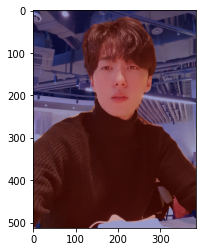

In [10]:
# leejaejun1.jpg
img1_show = img1_resized.copy()
seg1_map = np.where(seg1_map == 15, 15, 0) # 예측 중 사람만 추출
img1_mask = seg1_map * (255/seg1_map.max()) # 255 normalization
img1_mask = img1_mask.astype(np.uint8)
color1_mask = cv2.applyColorMap(img1_mask, cv2.COLORMAP_JET)
img1_show = cv2.addWeighted(img1_show, 0.6, color1_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img1_show, cv2.COLOR_BGR2RGB))
plt.show()

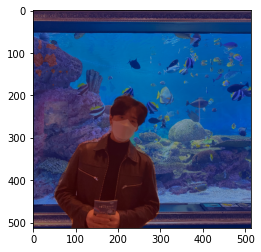

In [11]:
# leejaejun2.jpg
img2_show = img2_resized.copy()
seg2_map = np.where(seg2_map == 15, 15, 0) # 예측 중 사람만 추출
img2_mask = seg2_map * (255/seg2_map.max()) # 255 normalization
img2_mask = img2_mask.astype(np.uint8)
color2_mask = cv2.applyColorMap(img2_mask, cv2.COLORMAP_JET)
img2_show = cv2.addWeighted(img2_show, 0.6, color2_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. Segmentation 결과를 원래 크기로 복원

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 했다.  

세그맨테이션 결과 (mask)를 원래 크기로 복원해보자.

- `cv2.resize()` 함수를 이용  

-  크기를 키울 때 보간(interpolation) 을 고려해야 함  
  -> 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법  
   ->`cv2.INTER_NEAREST` 를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 `cv2.INTER_LINEAR` 를 사용
  
  
- 결과적으로 `img_mask_up` 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음
  
  
- 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정  
  -> 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

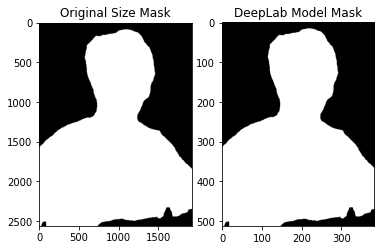

In [12]:
# leejaejun1.jpg
img1_mask_up = cv2.resize(img1_mask, img1_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img1_mask_up = cv2.threshold(img1_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img1_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img1_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

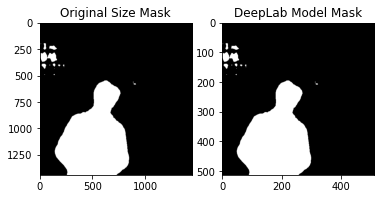

In [20]:
# leejaejun2.jpg
img2_mask_up = cv2.resize(img2_mask, img2_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img2_mask_up = cv2.threshold(img2_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img2_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img2_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 5. 배경 흐리게 하기  

`blur()` 함수를 이용해서 배경을 흐리게 만들자.

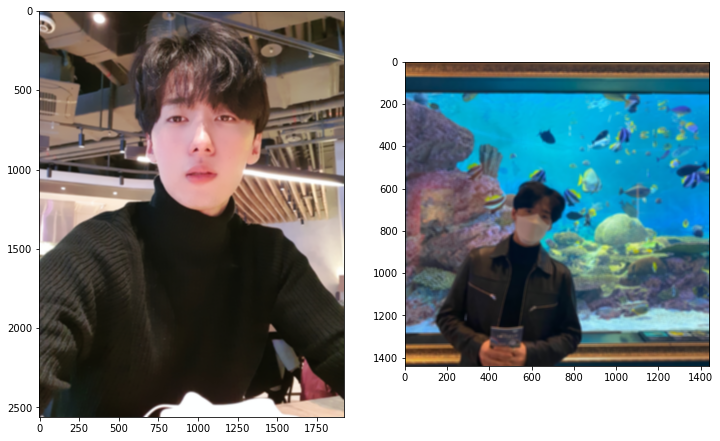

In [26]:
# leejaejun1.jpg
img1_orig_blur = cv2.blur(img1_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
# leejaejun2.jpg
img2_orig_blur = cv2.blur(img2_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 

# 시각화
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_orig_blur, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 흐려진 이미지에서 배경 추출
흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하자.

- `bitwise_not` 함수를 이용해서 이미지 반전 -> 배경은 `255`, 사람은 `0` 이 됨
- 반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상 얻을 수 있음

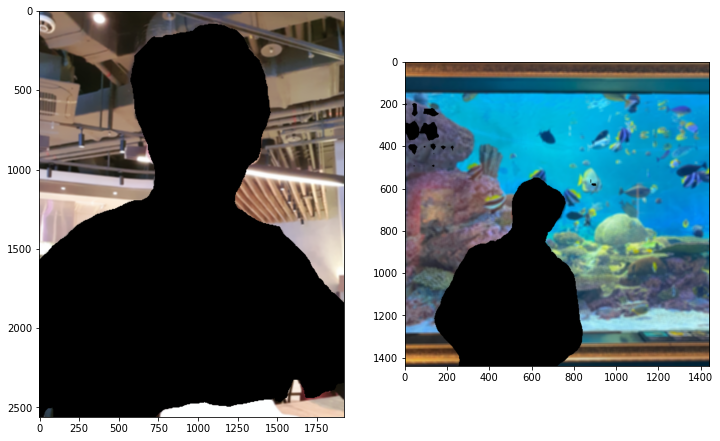

In [29]:
# leejaejun1.jpg
img1_mask_color = cv2.cvtColor(img1_mask_up, cv2.COLOR_GRAY2BGR)
img1_bg_mask = cv2.bitwise_not(img1_mask_color)
img1_bg_blur = cv2.bitwise_and(img1_orig_blur, img1_bg_mask)

# leejaejun1.jpg
img2_mask_color = cv2.cvtColor(img2_mask_up, cv2.COLOR_GRAY2BGR)
img2_bg_mask = cv2.bitwise_not(img2_mask_color)
img2_bg_blur = cv2.bitwise_and(img2_orig_blur, img2_bg_mask)


# 시각화
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_bg_blur, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

## 6. 흐린 배경과 사람 이미지 합성

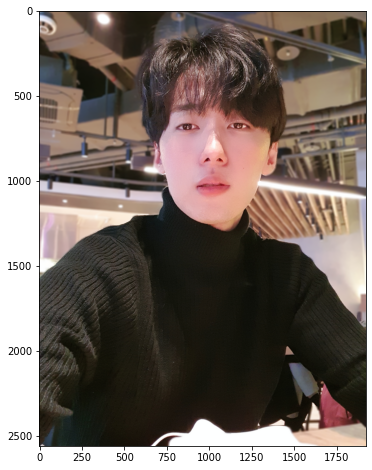

In [31]:
# leejaejun1.jpg
img1_concat = np.where(img1_mask_color==255, img1_orig, img1_bg_blur)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))
plt.show()

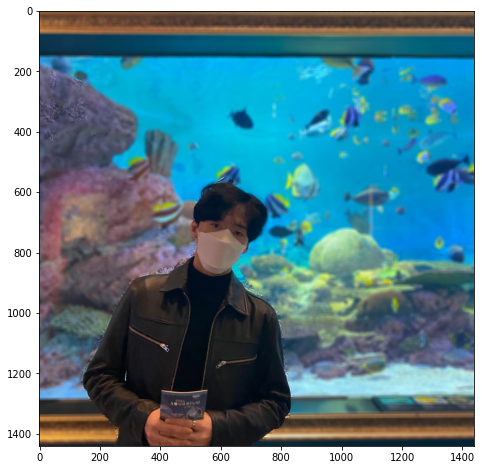

In [32]:
# leejaejun2.jpg
img2_concat = np.where(img2_mask_color==255, img2_orig, img2_bg_blur)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 원본 이미지와 비교

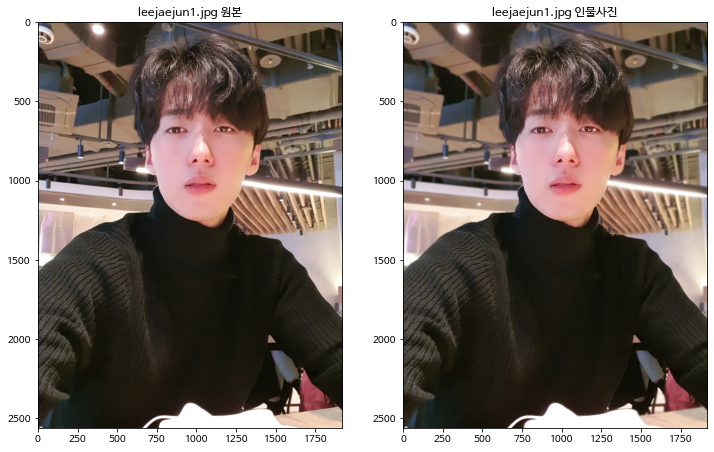

In [35]:
import matplotlib as mat
mat.rcParams['font.family'] = 'NanumBarunGothic'

# leejaejun1.jpg
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))
plt.title('leejaejun1.jpg 원본')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))
plt.title('leejaejun1.jpg 인물사진')

plt.show()

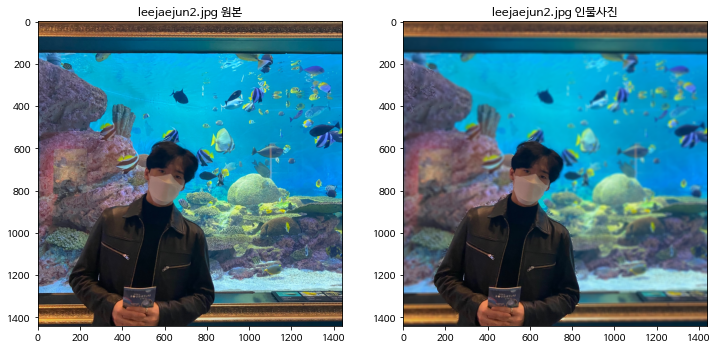

In [36]:
# leejaejun2.jpg
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.title('leejaejun2.jpg 원본')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.title('leejaejun2.jpg 인물사진')

plt.show()